[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/convergence_analysis.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/convergence_analysis.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/convergence_analysis.ipynb)

## [Paweł Magnuszewski MSc project](https://doi.org/10.48550/arXiv.2505.24435)

## arithmetic Asian call valuation - MPDATA convergence analysis

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import os
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PyMPDATA import Options

from PyMPDATA_examples.Magnuszewski_et_al_2025.asian_option import AsianArithmetic, Settings
from tqdm import tqdm
from PyMPDATA_examples.Magnuszewski_et_al_2025.monte_carlo import BSModel, FixedStrikeArithmeticAsianOption

In [3]:
mc_n_paths = 10000 if 'CI' not in os.environ else 10000
mc_seed = 42
mc_path_points = 1000

SETTINGS = Settings(
    T=1,
    K=100,
    r=.05,
    sgma=.4,
    S_max=200,
    S_min=50,
)
variant = "call"

OPTIONS_mpdata = Options(
        n_iters=2,
        nonoscillatory=True,
        non_zero_mu_coeff=True,
    )

OPTIONS_upwind = Options(
        n_iters=1,
        non_zero_mu_coeff=True,
    )


In [4]:
def asian_mc_at_spot(spot):
    mc_model = BSModel(
        T=1,
        sigma=0.4,
        r=0.05,
        M=mc_path_points,
        S0=spot,
        seed=mc_seed
    )
    arithmetic_option = FixedStrikeArithmeticAsianOption(1, 100, variant, mc_model, mc_n_paths)
    return arithmetic_option.price_by_mc()

In [5]:
def calculate_l2_norm(array1, array2, ny, nt):
    nx = len(array1)
    return np.sqrt(np.sum((array1 - array2) ** 2) / (nx * ny * nt))

In [6]:
scales = [1, 2, 4, 8, 16]

In [7]:
base_resolution = {
    'nt': 100,
    'nx': 5,
    'ny': 5,
}
l2_errors = {"MPDATA": [],
         "UPWIND": []}

In [8]:
biggest_scale = max(scales)
dummy_resolution = {k: v * biggest_scale + 1 for k, v in base_resolution.items()}
dummy_simulation = AsianArithmetic(SETTINGS, **dummy_resolution, options=OPTIONS_mpdata, variant=variant)
most_discretized_domain = dummy_simulation.S.copy()

max_mc_domain = np.zeros_like(most_discretized_domain)
for idx, spot in tqdm(enumerate(most_discretized_domain), total=len(most_discretized_domain), desc="Calculating MC prices at discretized domain"):
    max_mc_domain[idx] = asian_mc_at_spot(spot)

Calculating MC prices at discretized domain: 100%|██████████| 81/81 [01:17<00:00,  1.05it/s]


In [9]:
for scale in scales:
    resolution_scaled = {k: v * scale + 1 for k, v in base_resolution.items()}
    simulation_mpdata = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_mpdata, variant=variant)
    simulation_mpdata.step(simulation_mpdata.nt)
    simulation_price_mpdata = simulation_mpdata.solver.advectee.get()[:, 0]
    
    simulation_upwind = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_upwind, variant=variant)
    simulation_upwind.step(simulation_upwind.nt)
    simulation_price_upwind = simulation_upwind.solver.advectee.get()[:, 0]
    
    arithmetic_by_mc = np.interp(simulation_mpdata.S, most_discretized_domain, max_mc_domain)
    l2_errors["MPDATA"].append(calculate_l2_norm(simulation_price_mpdata, arithmetic_by_mc, simulation_mpdata.ny, simulation_mpdata.nt))
    l2_errors["UPWIND"].append(calculate_l2_norm(simulation_price_upwind, arithmetic_by_mc, simulation_upwind.ny, simulation_upwind.nt))

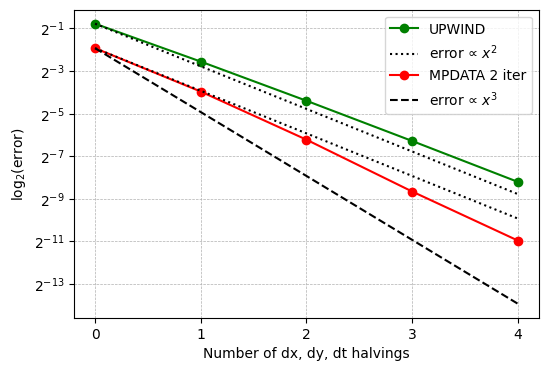

In [10]:
divisions = [np.log2(scale) for scale in scales]
simulated_errors_upwind = [l2_errors["UPWIND"][0] / (scale ** 2) for scale in scales]
simulated_errors_mpdata_t2 = [l2_errors["MPDATA"][0] / (scale ** 2) for scale in scales]
simulated_errors_mpdata_t3 = [l2_errors["MPDATA"][0] / (scale ** 3) for scale in scales]

fig, ax = pyplot.subplots(figsize=(6, 4))
ax.set_xlabel("Number of dx, dy, dt halvings")
ax.set_xticks(divisions)
ax.set_ylabel(f'log$_2$(error)')
ax.set_yscale('log', base=2)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.plot(divisions, l2_errors["UPWIND"], marker='o', linestyle='-', color='g', label='UPWIND')
ax.plot(divisions, simulated_errors_upwind, linestyle=':', color='k', label='error ∝ $x^2$')
ax.plot(divisions, l2_errors["MPDATA"], marker='o', linestyle='-', color='r', label='MPDATA 2 iter')
ax.plot(divisions, simulated_errors_mpdata_t2, linestyle=':', color='k')
ax.plot(divisions, simulated_errors_mpdata_t3, linestyle='--', color='k', label='error ∝ $x^3$')
ax.legend()
show_plot("convergence_analysis.pdf", inline_format='png')